### PARTICLE SWARM EN PARALELO (Prueba para 30 fuerzas de venta)

En una segunda aproximación, se procedió a implementar en paralelo el cálculo de las rutas óptimas de 30 fuerzas de venta (empleados). Dichas rutas fueron obtenidas a través del algortimo de particle swarm.

En este caso, el número de procesos que se corren en paralelo corresponde al número de Cores disponibles. En línea con lo anterior, el cálculo de las rutas de los 30 empleados es distribuido entre los Cores disponibles. Particularmente la prueba que se muestra enseguida considera 4 Cores, por lo tanto correrán 4 procesos en paralelo.

In [1]:
import dask
import time
import pandas as pd
import particle_swarm as ps

In [2]:
from dask.distributed import Client, progress
client = Client(threads_per_worker=4, n_workers=1)
client

Client Scheduler: tcp://127.0.0.1:39819 Dashboard: /user/dask-dask-examples-1f4xg9kz/proxy/8787/status,Cluster Workers: 1 Cores: 4 Memory: 2.15 GB


#### Definición de Funciones

In [3]:
def Crear_listas_empleados(lista_empleados,num_cores):
    '''
    Función que crea tantas listas como Cores se tengan disponibles y distribuye a las fuerzas de venta entre dichas listas.
    
    Args:
        lista_empleados(list): lista con los id's de todos los empleados (fuerzas de venta)
        num_cores(int): número de cores con los que cuenta el sistema
    Return:
        lista_total(list): lista formada a su vez por listas (igual al número de cores); tal que cada lista contiene un determinado número de empleados. 
    '''
    num_empleados = len(lista_empleados)
    residuo_empleados = num_empleados - num_cores
    lista_total = []
    
    
    # Creación de tantas listas como número de cores y primer llenado de estas listas
    for core in range(0,num_cores):
        lista_total.append([lista_empleados[core]])
     
    # Acomodar en las listas el resto de empleados
    for empleado in range(num_cores,num_empleados):
        posicion_lista_total = empleado%num_cores
        lista_total[posicion_lista_total].append(lista_empleados[empleado])
    
    return lista_total

In [4]:
#@dask.delayed
def ejecucion_algoritmo(lst_empleados):
    '''
    Función que ejecuta el algoritmo particle swarm.
    
    Args:
        lst_empleados(list): lista formada por uno o más empleados (fuerza de venta)
    Return:
        0(int): 0 al finalizar la ejecución del algoritmo de particle swarm
    '''
    for empleado in lst_empleados:
        # grafo completo
        grafo = df_data
        
        # hiperparámetros de particle swarm
        dict_Hiper = {'Iteraciones': 10,
              'Particulas': 10,
              'Alfa': .9,
              'Beta': 1
              }
        
        # Se instancia el objeto
        PS = ps.ParticleSwarm(grafo,dict_Hiper)
        
        # Ejecución de Particle Swarm
        PS.Ejecutar()
        #time.sleep(1)
    return 0

In [5]:
@dask.delayed
def ejecucion_paralelo(lst_empleados):
    '''
    Función que a su vez prepara funciones que posteriormente serán ejecutadas en paralelo;
    las convierte en funciones lazy, por lo que su resultado no será calculado inmediatamente, 
    si no que será almacenado como una tarea dentro de un grafo, que posteriormente será
    ejecutado en paralelo.
    
    Args:
        lst_empleados(list): lista formada por uno o más empleados (fuerza de venta)
    Return:
        task(): ejecución del algoritmo particle swarm como función lazy, que después será ejecutada en paralelo
    '''
    task = ejecucion_algoritmo(lst_empleados)
    return task

In [6]:
@dask.delayed
def juntar_ejecuciones(*arg):
    '''
    Función que permitirá ejecutar procesos en paralelo.
    Esta función también es considerada una función lazy
    
    Args:
        *arg(list): lista formada a su vez por listas, tal que cada lista representa un proceso a correr
    Return:
        arg(): función lazy que es almacenada como una tarea dentro de un grafo, la cual
                posteriomente ejecutará en paralelo tantos procesos como sublistas haya
    '''
    #time.sleep(1)
    return arg

#### Datos a utilizar

Por tratarse de una prueba, se está considerando que todos los empleados tienen el mismo grafo, es decir, que todos deben visitar los mismos puntos.

In [7]:
#DATOS

total_empleados = list(range(0,32))
num_cores = 4

# Creación de listas de empleados dependiendo del número de Cores disponibles
lista_empl = Crear_listas_empleados(total_empleados,num_cores)


# Definición del grafo de los empleados
data = {'nodo_origen':  [0,0,0,0,1,1,1,2,2,3],
        'nodo_destino':[1,2,3,4,2,3,4,3,4,4],
        'distancia':[1,3,4,5,1,4,8,5,1,2]
        }

# Transformación del grafo en dataframe, que es el formato aceptado por el algoritmo de particle swarm
df_data = pd.DataFrame (data, columns = ['nodo_origen','nodo_destino','distancia'])

print('División de empleados en 4 listas: \n',lista_empl)

División de empleados en 4 listas: 
 [[0, 4, 8, 12, 16, 20, 24, 28], [1, 5, 9, 13, 17, 21, 25, 29], [2, 6, 10, 14, 18, 22, 26, 30], [3, 7, 11, 15, 19, 23, 27, 31]]


#### Ejecución en Paralelo

In [8]:
# Definición de la lista en donde se almacenarán las funciones lazy que posteriormente serán ejecutadas en paralelo
lista_ejecuciones = []

# Llenado de lista_ejecuciones
for empleados in lista_empl:
    dask_Ejecucion = ejecucion_paralelo(empleados)
    lista_ejecuciones.append(dask_Ejecucion)
    
print('Funciones lazy:')
lista_ejecuciones

Funciones lazy:


[Delayed('ejecucion_paralelo-1d32ff2f-15f3-4e79-a67e-d9fbf594a2e0'),
 Delayed('ejecucion_paralelo-f485ee2b-d1ab-4ed7-b35d-e03060afb86d'),
 Delayed('ejecucion_paralelo-ef9f8e1b-1cca-46df-bc3a-7f5ec2fccbc5'),
 Delayed('ejecucion_paralelo-a235f881-d7fb-401f-be31-4a6b1842a216')]

Es importante mencionar que cada función lazy, involucra a su vez funciones lazy de 8 empleados. Es decir, deberán ejecutarse 4 funciones lazy (a las que nos referiremos como procesos) para poder obtener las rutas óptimas de los 32 empleados. Por lo tanto, al tener 4 Cores, se ejecutará 1 función lazy en cada Core.

In [9]:
# Definición de función lazy z, cuya ejecución permitirá la ejecución en paralelo de 
# las 4 funciones lazy definidas arriba

z = juntar_ejecuciones(lista_ejecuciones)

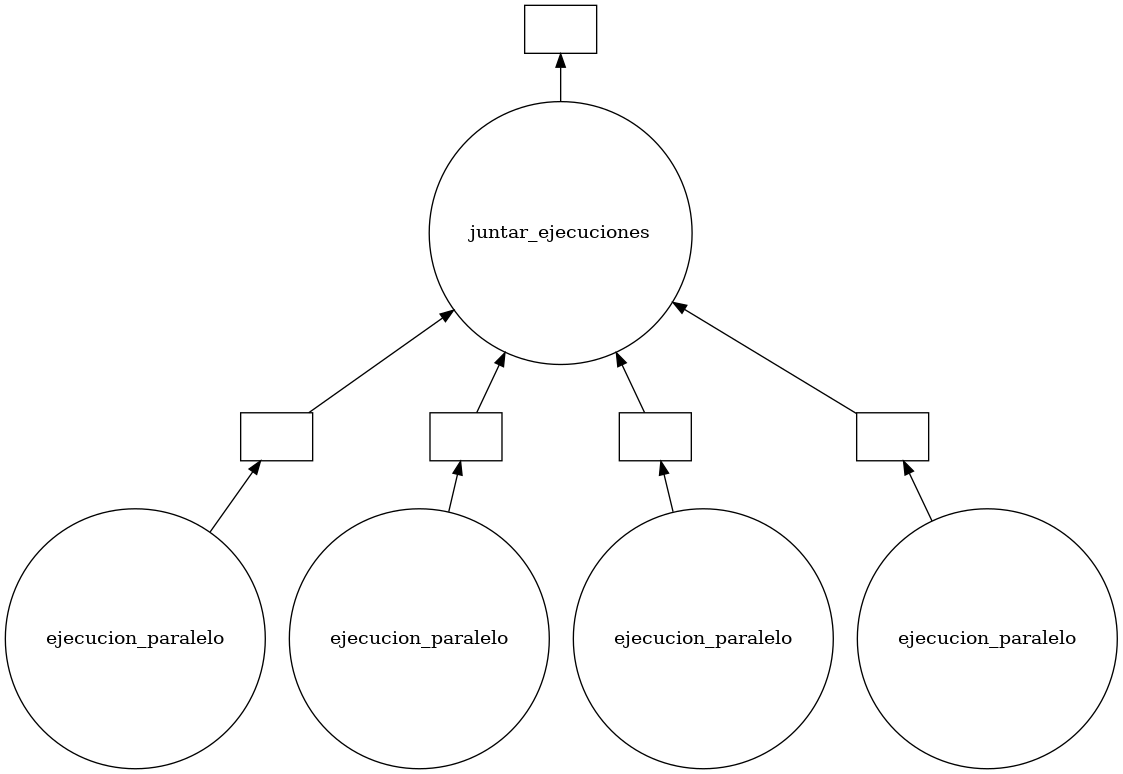

In [10]:
# Visualización de los procesos a ejecutarse en paralelo

z.visualize()

El diagrama anterior muestra que serán ejecutados 4 procesos en paralelo (uno en cada Core); y la ejecución de dichos procesos se logrará ejecutando únicamente la función `juntar_ejecuciones`. Esta representación ejemplifica las funciones lazy, es decir, todo está preparado para ejecutarse en paralelo; pero dicha ejecución ocurrirá hasta el momento en que el método `.compute()` sea aplicado a la función `juntar_ejecuciones`.

In [11]:
%%time

# Cálculo de los procesos en paralelo, es decir, cálculo de las rutas óptimas para las 30 fuerzas de venta, a través de 4 procesos dividos en 4 Cores
z.compute()

CPU times: user 51.2 ms, sys: 16.6 ms, total: 67.8 ms
Wall time: 872 ms


([0, 0, 0, 0],)

Los 4 ceros que aparecen en la ejecución anterior son debidos al return colocado en la ejecución de la función `ejcucion_algoritmo`. Su aparición indica que los 4 procesos fueron realizados. Es decir que cada proceso calculó la ruta óptima de 8 empleados.
